In [1]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import datetime as dt
import statsmodels.api as sm
from scipy import stats

In [2]:
import warnings
warnings.simplefilter(action='ignore')

In [3]:
os_path = os.getcwd()
energy_df = pd.read_pickle(os.path.dirname(os_path)+'\\data\\energycons.pkl')

In [4]:
energy_df = energy_df['Load']

In [5]:
#aggregate to daily 
energy_df = energy_df.groupby(energy_df.index.strftime('%Y-%m-%d')).mean()
energy_df.index = pd.to_datetime(energy_df.index)

#limit the data only up to the end of 2020
energy_df = energy_df.loc[energy_df.index<'2021-01-01']
energy_df.head()

2015-01-01    4994.333333
2015-01-02    5249.416667
2015-01-03    5057.916667
2015-01-04    5230.083333
2015-01-05    5596.916667
Name: Load, dtype: float64

# Time Series Intro

The goal of this notebook is to introduce the most common patterns, observed in time series, and the assumptions underlying most statistical time series models. It goes over commonly observed types of processes, how to recognize them, and what are some fitting models to forecast them. 

# Descriptive statistics for TS/EDA

Think of the time series ($x_t$) as a **realization of a stochastic process**, described by a T-dimensional probability distribution;forecasts are also random variables with confidence bands and *point estimates*. In standard statistics, we usually talk about a sample consisting of seveleral, typically independent draws from the same distribution; in time series analysis we technically have just one observation (one trajectory).

We always start by plotting the data and observe the series for any consistent patterns or features. We can find four main types of patterns in a time series process:
 - trend
 - seasonality
 - cyclical
 - noise (random innovations)

## Examples of time series data
### White noise: $Z_t \sim WN(0, \sigma^2) $
The WN is a stationary and temporally non-correlated process. It is also the building block for other common types of time series we observe with a more complex autocorrelation structure.  

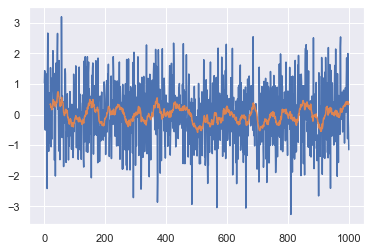

In [6]:
white_noise = pd.Series(np.random.randn(1000))
white_noise_ma = white_noise.rolling(20).mean()

plt.plot(white_noise);
plt.plot(white_noise_ma);

### Random walk: $X_t = \sum_{t = 1}^{T}Z_t$
Random walks are a common example of non-stationary processes. Some typical examples nonstationary series, driven by random walks, are stock prices and exchange rates. We usually have to apply some form of transformation to the raw series, in order to achieve stationarity.

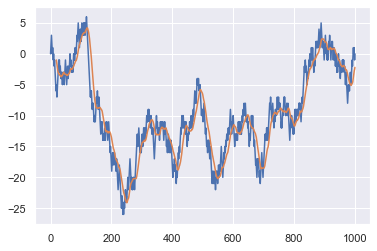

In [7]:
import random 

def simRandomWalk(prob, n):
    x = random.choices([-1 ,1], weights =[1-prob, prob], k=n)
    s = np.append([0], np.cumsum(x))
    return s

random_walk = pd.Series(simRandomWalk(0.5, 1000))
random_walk_ma = random_walk.rolling(20).mean()

plt.plot(random_walk);
plt.plot(random_walk_ma);

## AR(1) process: $X_t = Z_t + \theta X_{t-1}$

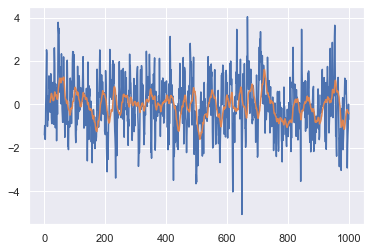

In [8]:
def simAR1 (alpha, N):
    normDist = stats.norm(0 , 1)
    x = normDist.rvs(N + 1)
    for i in range (N):
        x[i+1] = x[i+1] + alpha*x[i]
    return x

ar1_process = pd.Series(simAR1(0.6, 1000))
ar1_process_ma = ar1_process.rolling(20).mean()

plt.plot(ar1_process);
plt.plot(ar1_process_ma);

## MA(1) process: $X_t = Z_t + \theta Z_{t-1}$

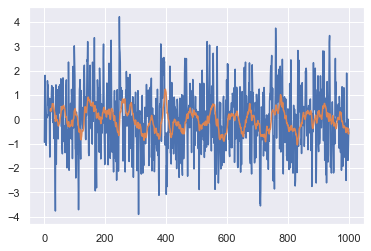

In [9]:
def simMA1(alpha, N):
    normDist = stats.norm(0,1)
    x = np.zeros((N))
    #draw innovations
    err = normDist.rvs(N)
    x[0] = err[0]
    for i in range (1, N):
        x[i] = err[i] + alpha*err[i-1]
    return x

ma1_process = pd.Series(simMA1(0.8, 1000))
ma1_process_ma = ma1_process.rolling(20).mean()

plt.plot(ma1_process);
plt.plot(ma1_process_ma);

## Trend with noise

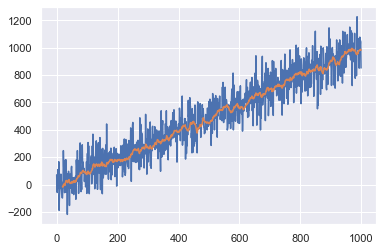

In [10]:
trend = np.arange(1000)
noise = np.random.randn(1000)*100
trend_wn = pd.Series(trend + noise)
trend_wn_ma = trend_wn.rolling(20).mean()

plt.plot(trend_wn);
plt.plot(trend_wn_ma);

## Seasonality with noise (our data for this notebook)

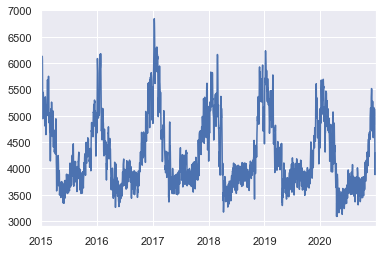

In [11]:
energy_df.plot();

As a first step, we can smooth the noise or regular patterns in the data by plotting a moving average of the series.

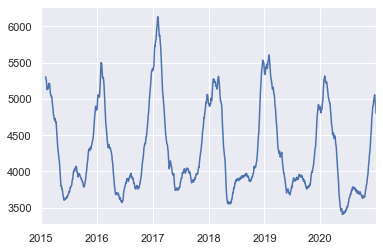

In [12]:
energy_df.rolling(30).mean().plot();

As we increase the size of the rolling window, the series becomes more smooth and we observe the underlying trend (if one exists).

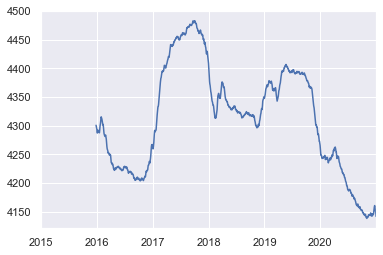

In [13]:
energy_df.rolling(360).mean().plot();

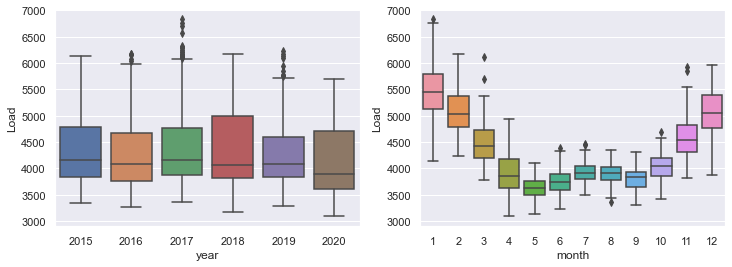

In [15]:
fig, axes = plt.subplots(1, 2, figsize=(12,4))

sns_graph = pd.DataFrame(energy_df).copy()
sns_graph['year'] = sns_graph.index.year
sns_graph['month'] = sns_graph.index.month

sns.boxplot(x="year", y="Load", data=sns_graph, ax = axes[0]);
sns.boxplot(x="month", y="Load", data=sns_graph, ax = axes[1]);

# Time series data transformations

In order to make any meaningful statistical analysis, we need to assume that the observed part of the
stochastic process is typical for the time series as a whole. Two concepts are tightly related to this: *stationarity* and *ergodicity*.

There are some standard transformations that we often apply in order to ensure our assumptions are not violated. 
 - Distributional (also related to stationarity)
 - Stationarity inducing
 - Decompositional

# Distributional properties
We often need to apply some distributional transformations, as TS data can be skewed (for example often to the right, especially when the series is a measure of something that can only be positive).

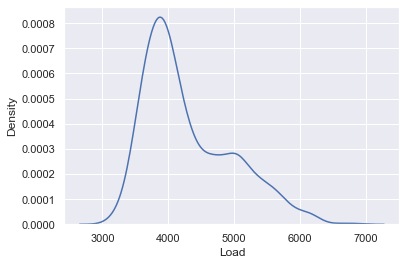

In [17]:
sns.kdeplot(energy_df);

## Possible transformations 

### Logarithm
Transforming the data into logarthims is a common practice, since it reduces the variance and smoothes the mean. Note that all observations have to be larger than 0 (or we can add the same constant (*shift parameter*) to all observations if the data and task at hand allows it).
### Box-Cox transformation

\begin{equation*}
f^{BC}(x_t, \lambda) = \begin{cases}
\dfrac{({x_t}^\lambda - 1)}{\lambda} & \quad \lambda \neq 0, \\
\log x_t & \quad \lambda = 0.
\end{cases}
\end{equation*}


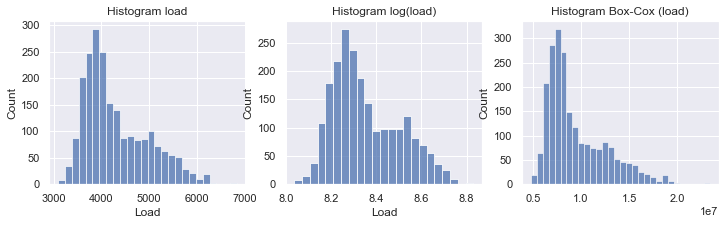

In [18]:
fig, axes = plt.subplots(1, 3, figsize=(12,3))

sns.histplot(energy_df, ax = axes[0]);
axes[0].set_title('Histogram load')

sns.histplot(np.log(energy_df), ax = axes[1]);
axes[1].set_title('Histogram log(load)');

sns.histplot(stats.boxcox(energy_df, lmbda = 2), ax = axes[2]);
axes[2].set_title('Histogram Box-Cox (load)');

In [12]:
energy_df = np.log(energy_df)

# Time Series Stationarity


### Ergodicity Assumption
Too complicated, lies within the ream of probability theory, but states that the observations of the stochastic process cover all possible events. 

### Stationarity
 
 - Weak stationarity implies:
  - 1st moment is constant over time
  - autocovariance is constant over time
  - 2nd moment is finite
 - Strict stationarity implies:
  - the unconditional joint probability distribution does not change over time
  
### Weak vs Strict Stationarity 
#### Does strict stationarity imply weak stationarity?
No. However if $E(X^2) < \infty$ for all $t$, then yes.
#### Does weak stationarity imply strict stationarity?
No. If higher moments, for example $E(x_t^3)$ are functions of time (GARCH processes). If we can assume joint normality however, the first two moments are enough to characterize the distribution, and weak stationarity implies strict stationarity as well.

### Trend vs Difference Stationarity
 - if a process needs to be differentiated d-times to arrive at stationarity, it is called integrated of order d, $X \sim I(d)$
 - if we need to eliminate a trend (by regressing the time series against a time polynomial of degree s), the series is trend-stationary
 
### Stationarity Tests

 - ADF test: $H_0$ = there is a unit root vs $H_\alpha$ = there isn't; different types of ADF:
  - no constant (drift) or trend in the OLS regression
  - constant (drift) in the OLS regression
  - constant (drift) and linear/quadratic trend
  - http://faculty.smu.edu/tfomby/eco6375/BJ%20Notes/ADF%20Notes.pdf
 - KPSS test:$H_0$ = the series is trend-stationary vs $H_\alpha$ = the series has a unit root
 - takeaways: stationarity test can sometimes give conflicting results; inference relies on proper specification of the test; cannot always be trusted? in auto arima models, results can vary depending on the stationarity test we choose

In [19]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss

def test_stationarity(series, crit='BIC'):
    print_tests = 'Stationarity tests \n \
    P-values for: ADF with drift: {0:0.3f}, ADF drift and trend: {1:0.3f}, ADF no drift or trend: {2:0.3f} \n \
    KPSS p-value: {3:0.3f}'
    adftest_c = adfuller(series, autolag='BIC', regression = 'c')
    adftest_ct = adfuller(series, autolag='BIC', regression = 'ct')
    adftest_nc = adfuller(series, autolag='BIC', regression = 'nc')
    kpsstest = kpss(series)

    return print(print_tests.format(adftest_c[1], adftest_ct[1], adftest_nc[1], kpsstest[1]))

In [20]:
test_stationarity(white_noise, 'BIC')
test_stationarity(ar1_process, 'BIC')
test_stationarity(ma1_process, 'BIC')

Stationarity tests 
     P-values for: ADF with drift: 0.000, ADF drift and trend: 0.000, ADF no drift or trend: 0.000 
     KPSS p-value: 0.100
Stationarity tests 
     P-values for: ADF with drift: 0.000, ADF drift and trend: 0.000, ADF no drift or trend: 0.000 
     KPSS p-value: 0.100
Stationarity tests 
     P-values for: ADF with drift: 0.000, ADF drift and trend: 0.000, ADF no drift or trend: 0.000 
     KPSS p-value: 0.100


In [21]:
test_stationarity(trend_wn, 'BIC')

Stationarity tests 
     P-values for: ADF with drift: 0.786, ADF drift and trend: 0.000, ADF no drift or trend: 0.951 
     KPSS p-value: 0.010


In [22]:
test_stationarity(random_walk, 'BIC')

Stationarity tests 
     P-values for: ADF with drift: 0.186, ADF drift and trend: 0.349, ADF no drift or trend: 0.172 
     KPSS p-value: 0.010


In [23]:
test_stationarity(energy_df, 'BIC')

Stationarity tests 
     P-values for: ADF with drift: 0.002, ADF drift and trend: 0.014, ADF no drift or trend: 0.383 
     KPSS p-value: 0.100


# Autocorrelation and partial autocorrelation functions (ACF and PACF)

### ACF
We might observal "internal" correlations within time series, or in other words - autocorrelations between the current value $x_t$ and previous (lagged) values $x_{t-k}$ for $k = 1, 2 ... n$. We define the sample lagged k-th autocorrelation as: <br>
 
$r_k = \dfrac{\sum_{t = k+1}^{T}(x_t - \bar{x})(x_{t-k}-\bar{x})}{Ts^2}$, where $\bar{x}$ and $s^2$ are the sample mean and sample standard deviation.

If a time series is stationary, the autocovariance and respectively the ACF should depend only on the number of lags, but on the particular point of time. 

### PACF
The partial autocorrelation funciton measures how much $X_1$ contributes to a linear forecast of $X_{t+1}$, **controlling** for $X_{t}, X_{t-1}, ..., X_2$. Denote the best linear predictor of $X_{t+1}$ as: <br>
$\mathrm{P}_t X_{t+1} = \alpha_1 X_t + \alpha_2 X_{t-1} + ... + \alpha_t X$, then $\alpha+t$ can be seen as a measure of importance for the additional information contributed by $X_1$ (PACF). For AR(p) process, all the information is contained in the $p$ lags; for the MA(q) process however, we can identify the innovations $Z$ from all current and previous observations (they are all contributing) 

### Rule of thumb for 'guessing' lag orders of an ARMA process
Using the ACF and PACF can be incredinly useful for modeling ARMA process. It is a vital step of the [Box-Jenkins forecasting method](https://en.wikipedia.org/wiki/Box%E2%80%93Jenkins_method), because they can be used to 'guess' the number of auto-regressive (p) and moving average (q) lags of the ARMA model. When using auto-arima packages, the ACF and PACF can be used both as a sanity check, or as a guide of what ranges to set for the grid search.

|  | ACF | PACF |
| --- | --- | --- |
| AR(p) process| decays exponentially (monotonically or oscillating to zero) | p lags |
| MA(q) process | q lags | decays exponentially (monotonically or oscillating to zero) |

In [24]:
def plot_acf_pacf(series, nlags):
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    
    sm.graphics.tsa.plot_acf(series, lags=nlags, ax = axes[0])
    axes[0].set_title('Sample ACF')

    sm.graphics.tsa.plot_pacf(series, lags=nlags, ax = axes[1])
    axes[1].set_title('Sample PACF')
    
    return fig

### White noise process ACF and PACF
The WN process is both stationary and temporally uncorrelated by definition - therefore the ACF should be 0 everywhere, but at lag $h=0$, where it equals 1. We can also say that WN is a process without memory.

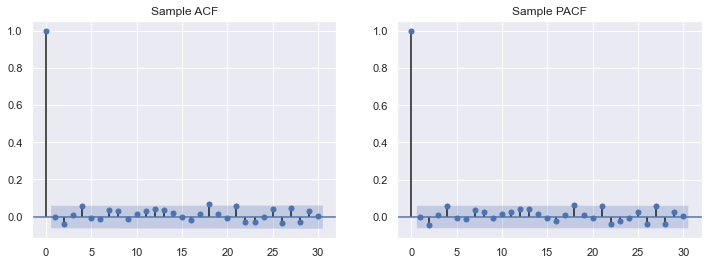

In [25]:
#White Noise
plot_acf_pacf(white_noise, 30);

### Trend with white noise 
The non-decreasing ACF hints that the process is not stationary.

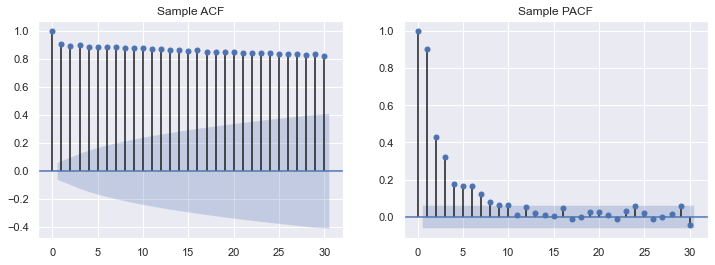

In [27]:
#Trend with white noise
plot_acf_pacf(trend_wn, 30);

### Random walk
ACF shows clear non-stationarity; in the PACF we can see the highly singificant first lag, with a coefficient close to 1.

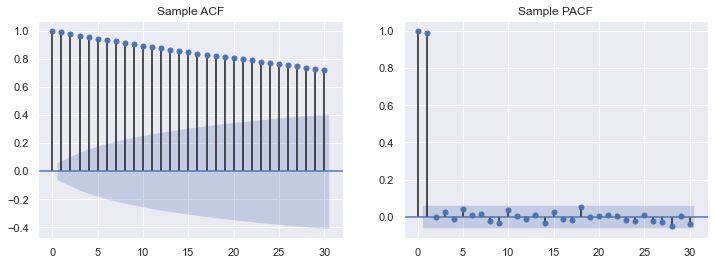

In [32]:
#Trend with white noise
plot_acf_pacf(random_walk, 30);

### AR(1) process
The ACF decays slowly, whereas in the PACF we can see only the first lag is significant; characteristic for an AR(1) process.

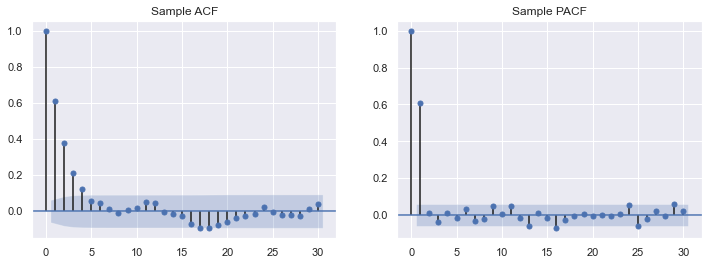

In [28]:
#AR(1) process
plot_acf_pacf(ar1_process, 30);

### MA(1) process
The PACF decays (in an oscillating manner) to 0, and the first lag of the ACF is significant - typical for an MA process.

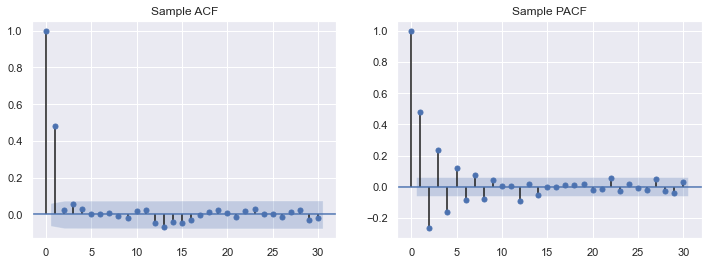

In [29]:
#MA(1) process
plot_acf_pacf(ma1_process, 30);

### Our data: energy consumption
We can see clear seasonality trend; the process reminds us also of a random walk.

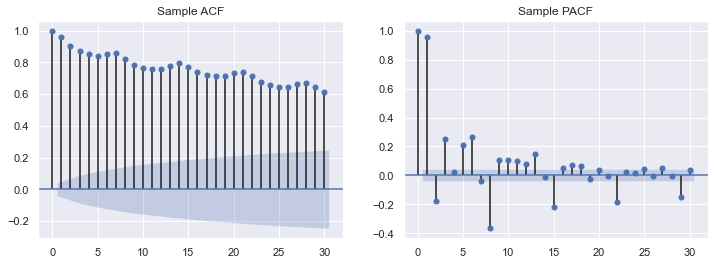

In [30]:
#Energy Data
plot_acf_pacf(energy_df, 30);

# Seasonality in TS data

Time series often show seasonality: repeating patterns at regular intervals. Depending on the frequency at which the series is observed, the seasonality may vary. 
 - Quarterly data: seasonality happens usually every four quarters
 - Monthly\weekly data: seasonality repeats every (close to) 365 days or 52 weeks

### Complex Seasonality

When we work with higher frequency data (daily, hourly, minutes, etc) we are likely to find multiple seasonalities in the series. For example, energy consumption is likely to be influenced both by the day of the week and the specific month\season of the year.


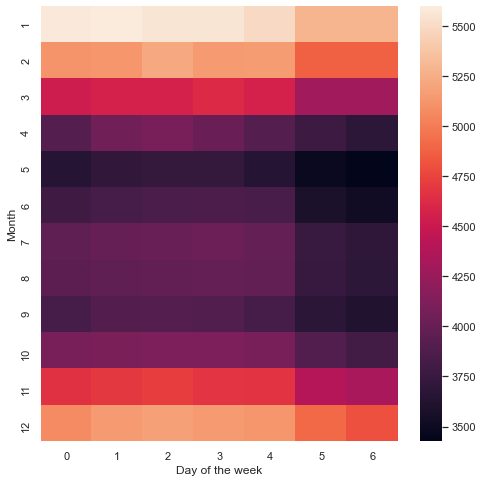

In [6]:
dfnew = pd.DataFrame(energy_df.copy())
dfnew['Month'] = energy_df.index.month
dfnew['Day of the week'] = energy_df.index.weekday

dfnew = pd.pivot_table(dfnew, values='Load', index=['Month'],
                     columns=['Day of the week'], aggfunc=np.mean, fill_value=0)

fig, ax = plt.subplots(figsize=(8,8))
sns.heatmap(dfnew);

## Seasonal Decomposition using moving average
statsmodels [documentation](https://www.statsmodels.org/stable/generated/statsmodels.tsa.seasonal.seasonal_decompose.html)

- Additive 
$X_t = T_t + S_t + I_t$
- Multiplicative
$X_t = T_t \times S_t \times I_t$

[additive vs multiplicative seasonality game](https://kourentzes.com/forecasting/2014/11/09/additive-and-multiplicative-seasonality/)

### Steps to estimate the decomposition
1. Use MA to find the trend of the series
2. Substract the trend from the series: <br>
$X_{SA, I} = X_t - T_t = S_t + I_t$
3. Use the identifying assumption that $\bar{I_t} = 0$
4. $S_t$ then can be calculated as the average of each quarter, month, etc accross years.
5. Calculate $I_t$ as the residual.

***Note that the distinction becomes somewhat artificial if we take the logarithm of a multiplicative series.

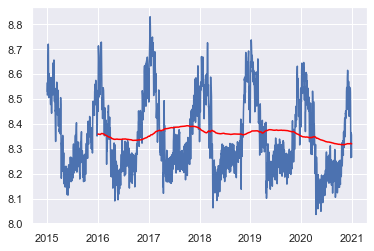

In [17]:
energy_df_ma = energy_df.rolling(365).mean()
#energy_df_ma_std = energy_df.rolling(365).std()

plt.plot(energy_df)
plt.plot(energy_df_ma, color='red');

### Naive seasonal decomposition based on moving average of the series
We estimate the centered (two-sided) moving average for the seasonality preiod (4 for quarterly data, 12 for monthly and others).

$\text{WMA}_t(2n+1) = \sum_{i = -n}^{n}w_i x_{t-i}$

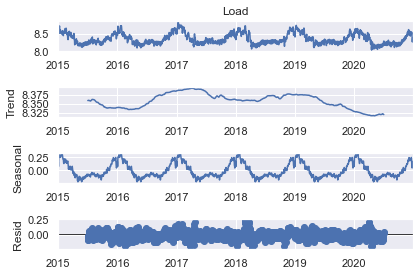

In [18]:
energy_df = energy_df.asfreq('d')
from statsmodels.tsa.seasonal import seasonal_decompose
results_additive = seasonal_decompose(energy_df, model='additive', period = 365)
results_additive.plot();

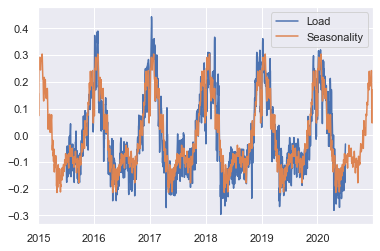

In [19]:
graph = pd.DataFrame(energy_df - energy_df.rolling(365, center=True).mean())
graph['Seasonality'] = results_additive.seasonal
graph.plot();

## Complex/Multiple seasonalities
Some series have more complex seasonality patterns. The daily electricity load, for example, has both annual and weekly seasonality. After extracting the annual seasonal component from the initial series, we can re-apply the the naive seasonality decomposition procedures to the residuals we have derived.

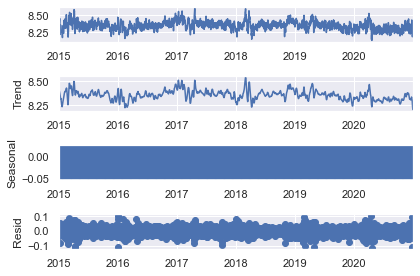

In [20]:
decomp_annual_df = energy_df - results_additive.seasonal
results_additive_weekly = seasonal_decompose(decomp_annual_df, model='additive', period = 7)
results_additive_weekly.plot();

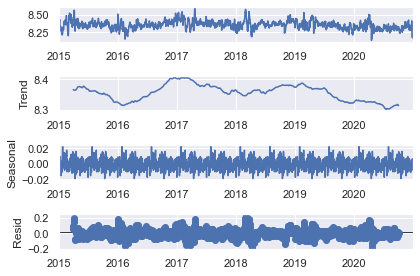

In [21]:
decomp_df = decomp_annual_df - results_additive_weekly.seasonal
results_additive_ann2 = seasonal_decompose(decomp_df, model='additive', period = int(366/2))
results_additive_ann2.plot();

In [22]:
decomp_df = decomp_df - results_additive_ann2.seasonal

### OLS regression
We can also run an OLS regression with dummies for the days of the week on the residuals, and we can see the effect each weekday has on the total load.

In [24]:
weekday_df = pd.DataFrame(decomp_annual_df, index = pd.to_datetime(decomp_annual_df.index), columns=['y'])
weekday_df['dayoftheweek'] = weekday_df.index.weekday
X = pd.get_dummies(weekday_df['dayoftheweek'], prefix='day', drop_first=True)

X = sm.add_constant(X)
model = sm.OLS(weekday_df['y'], X)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.187
Model:                            OLS   Adj. R-squared:                  0.185
Method:                 Least Squares   F-statistic:                     83.95
Date:                Wed, 10 Feb 2021   Prob (F-statistic):           7.93e-95
Time:                        13:03:58   Log-Likelihood:                 3115.6
No. Observations:                2192   AIC:                            -6217.
Df Residuals:                    2185   BIC:                            -6177.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          8.3641      0.003   2529.371      0.0

## STL decomposition

 - Two main hyperpar-s to be chosen: trend-cycle window and seasonal window

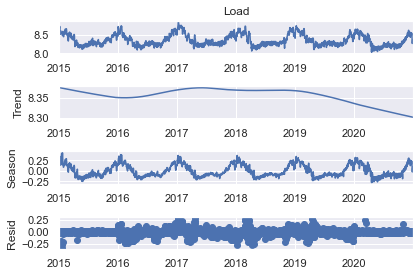

In [25]:
from statsmodels.tsa.seasonal import STL
stl = STL(energy_df, period=365, robust=True)
res_STL = stl.fit()
fig = res_STL.plot()

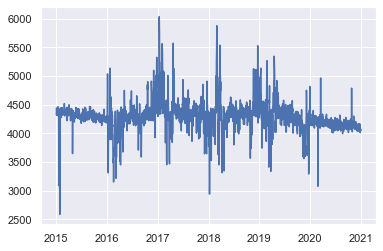

In [25]:
newdf = energy_df - res_STL.seasonal
plt.plot(newdf);

### Spectral analysis using FFT
Every time series can be analyzed in the time domain or as overlayed waves of different frequencies (frequency domain). The decomposition of a time series into sinusoids of different frequencies is called the spectral representation. From a mathematical point of view, the equivalence between time and frequency domain analysis rest on the theory of Fourier series. The spectral density is defined as the Fourier transform of the ACF.

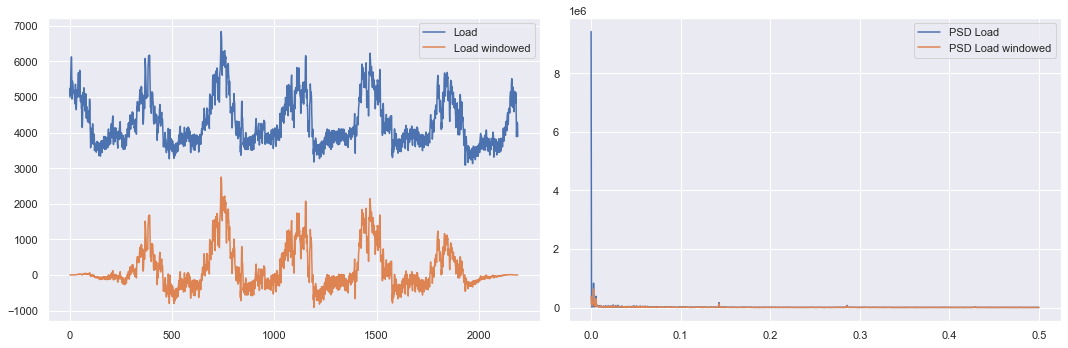

In [44]:
from numpy.fft import rfft, rfftfreq
from scipy.signal import tukey
from numpy.fft import fft, fftshift

def fft_tuckey_transform(series, d):
    t_series = np.linspace( 0, len(series)/1, len(series), endpoint=False )
    #note that the choice of window matters
    series_window = (series-np.median(series))*tukey(len(series))

    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,5))

    ax[0].plot(t_series, series, label='Load')
    ax[0].plot(t_series, series_window, label='Load windowed' )
    ax[0].legend()

    series_fft = abs(rfft(series))
    series_tukey = abs(rfft(series_window) )

    #set d to the inverse of the step (365 days in 1 year if you want to set for years)
    #currently set to days
    series_freqs = rfftfreq( len(series), d = 1/d)


    ax[1].plot(series_freqs[:], series_fft[:], label='PSD Load' )
    ax[1].plot(series_freqs[:], series_tukey[:], label='PSD Load windowed' )
    ax[1].legend()

    plt.tight_layout()
    plt.show()

fft_tuckey_transform(energy_df, 1)

In [40]:
sm.tsa.stattools.periodogram(random_walk)

AttributeError: module 'statsmodels.tsa.stattools' has no attribute 'periodogram'

In [38]:
import scipy
scipy.signal.periodogram(random_walk)

(array([0.        , 0.000999  , 0.001998  , 0.002997  , 0.003996  ,
        0.004995  , 0.00599401, 0.00699301, 0.00799201, 0.00899101,
        0.00999001, 0.01098901, 0.01198801, 0.01298701, 0.01398601,
        0.01498501, 0.01598402, 0.01698302, 0.01798202, 0.01898102,
        0.01998002, 0.02097902, 0.02197802, 0.02297702, 0.02397602,
        0.02497502, 0.02597403, 0.02697303, 0.02797203, 0.02897103,
        0.02997003, 0.03096903, 0.03196803, 0.03296703, 0.03396603,
        0.03496503, 0.03596404, 0.03696304, 0.03796204, 0.03896104,
        0.03996004, 0.04095904, 0.04195804, 0.04295704, 0.04395604,
        0.04495504, 0.04595405, 0.04695305, 0.04795205, 0.04895105,
        0.04995005, 0.05094905, 0.05194805, 0.05294705, 0.05394605,
        0.05494505, 0.05594406, 0.05694306, 0.05794206, 0.05894106,
        0.05994006, 0.06093906, 0.06193806, 0.06293706, 0.06393606,
        0.06493506, 0.06593407, 0.06693307, 0.06793207, 0.06893107,
        0.06993007, 0.07092907, 0.07192807, 0.07

### stationarity testing, SACF and SPACF post seasonal decomposition

C:\Users\GerganaMarkova\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the same as nlags="auto" which uses an automatic lag length selection method. To silence this warning, either use "auto" or "legacy"
  warnings.warn(msg, FutureWarning)
C:\Users\GerganaMarkova\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\stattools.py:1906: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


Stationarity tests 
     P-values for: ADF with drift: 0.000, ADF drift and trend: 0.000, ADF no drift or trend: 0.526 
     KPSS p-value: 0.010


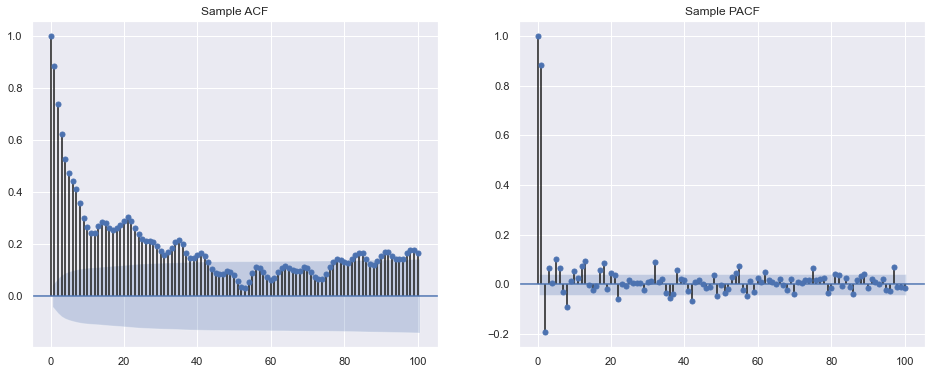

In [18]:
#decomp_df = decomp_annual_df - results_additive_weekly.seasonal
test_stationarity(decomp_df)
plot_acf_pacf(decomp_df, nlags = 100);

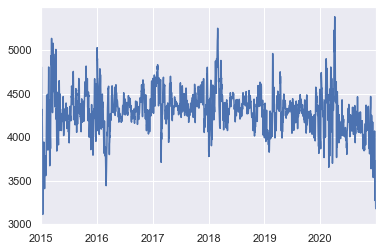

In [29]:
decomp_df.plot();

# ARIMA (p, d, q) models (autoregressive, integrated, moving average)


## Wald's Decomposition
Every weakly stationary, purely nondeterministic, stochastic process $x-\mu$ can be expressed as a linear combination of a sequence of random variables:
$x-\mu = a_t+\psi_1a_{t-1} + ... = \sum_{j = 0}^{\infty}\psi_j a_{t-j}$, where $a_t \sim WN(0, \sigma^2)$


- AR(p) models can be estimated by OLS (efficient estimator)
- ARMA(p, q) models are estimated using MLE, as the MA(q) process is not directly observed in the data
- ARMA can be used only on stationary, invertible and causal stochastic processes
- if the series is I(d), or integrated of order d, we can use the ARIMA(p, d, q) model

## Steps when modeling an ARMA/ARIMA process

#### Step 1: Transform the series to achieve stationarity
 - transform the series into log-s, difference or remove trend if necessary
 - remove seasonality
 
#### Step 2: Find the p and q order
 - investigate the sample ACF and PACF
 
#### Step 3: Diagnostics checking
 - observing the residuals from the fitted model for misspecifications such as
 - autocorrelated residuals (SACF), Ljung-Box test
 - overfit the model by including p+1/q+1 lags in order to check if they are significant
 - invesetigate out-of-sample performance of the mode, does it deliver sensible forecasts?

## Choosing lags (hyperpar-s) based on information criteria
- AIC: $AIC(p, q) = log\hat{\sigma}^2 + 2(p+q)T^{-1}$
- BIC: $BIC(p, q) = log\hat{\sigma}^2 + (p+q)T^{-1}logT$
- BIC is *strongly consistent*, or in other words chooses the 'true' model asymptotically, whereas AIC will choose an over-parametrized model (might be better for forecasting)

In [31]:
from statsmodels.tsa.ar_model import AutoReg
res = sm.tsa.arima.ARIMA(decomp_df, order=(7, 0, 0), enforce_stationarity=False).fit()
print(res.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 2192
Model:                 ARIMA(7, 0, 0)   Log Likelihood              -13419.608
Date:                Thu, 04 Feb 2021   AIC                          26857.217
Time:                        14:07:57   BIC                          26908.421
Sample:                    01-01-2015   HQIC                         26875.934
                         - 12-31-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       4300.2226     22.159    194.058      0.000    4256.791    4343.654
ar.L1          1.0165      0.014     71.763      0.000       0.989       1.044
ar.L2         -0.2325      0.021    -11.256      0.0

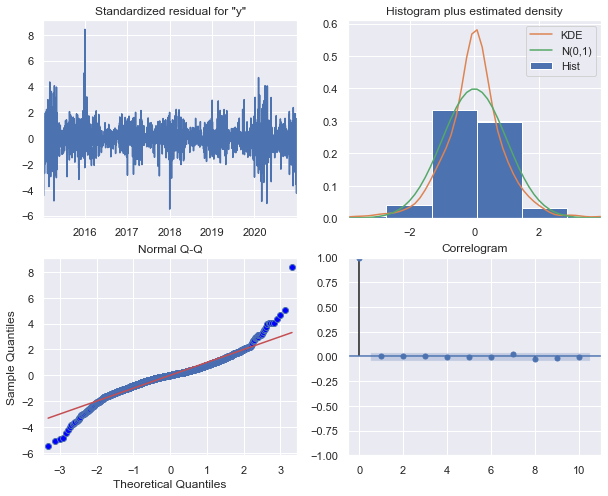

In [32]:
res.plot_diagnostics(figsize = (10, 8));

## ARCH/GARCH processes

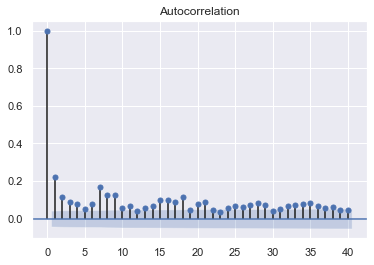

In [33]:
residuals = res.resid

sm.graphics.tsa.plot_acf(residuals**2, lags=40)
plt.show()

# Automized ways of tuning the ARIMA/SARIMA hyperpar-s

In [34]:
import pmdarima as pm
from pmdarima.model_selection import train_test_split

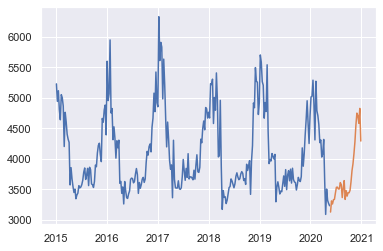

In [35]:
energy_weekly = energy_df.asfreq('w')
train, test = train_test_split(energy_weekly, train_size=int(0.9*len(energy_weekly)))
plt.plot(train)
plt.plot(test);

In [125]:
model = pm.auto_arima(train, start_p = 0, start_q = 0, 
                      max_p = 5, max_d = 2, max_q = 5, information_criterion='aic',
                      test = 'adf', max_P=2, max_D=1, max_Q=2, max_order=2, m=52, trace=True,
                      maxiter = 50, stepwise = True, seasonal=True)


Performing stepwise search to minimize aic
Fit ARIMA(0,0,0)x(1,0,1,52) [intercept=True]; AIC=4319.704, BIC=4334.257, Time=20.238 seconds
Fit ARIMA(0,0,0)x(0,0,0,52) [intercept=True]; AIC=4437.751, BIC=4445.028, Time=0.026 seconds
Fit ARIMA(1,0,0)x(1,0,0,52) [intercept=True]; AIC=4069.614, BIC=4084.168, Time=13.379 seconds


C:\Users\GerganaMarkova\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\statespace\sarimax.py:1006: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


Fit ARIMA(0,0,1)x(0,0,1,52) [intercept=True]; AIC=4197.216, BIC=4211.770, Time=12.183 seconds
Fit ARIMA(0,0,0)x(0,0,0,52) [intercept=False]; AIC=5484.192, BIC=5487.830, Time=0.024 seconds
Fit ARIMA(1,0,0)x(0,0,0,52) [intercept=True]; AIC=4074.219, BIC=4085.134, Time=0.083 seconds


C:\Users\GerganaMarkova\AppData\Roaming\Python\Python38\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


Fit ARIMA(1,0,0)x(2,0,0,52) [intercept=True]; AIC=4061.045, BIC=4079.237, Time=296.096 seconds
Near non-invertible roots for order (1, 0, 0)(2, 0, 0, 52); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.991)


C:\Users\GerganaMarkova\AppData\Roaming\Python\Python38\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


Fit ARIMA(1,0,0)x(1,0,1,52) [intercept=True]; AIC=4069.365, BIC=4087.556, Time=29.878 seconds


C:\Users\GerganaMarkova\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\statespace\sarimax.py:1006: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


Fit ARIMA(1,0,0)x(0,0,1,52) [intercept=True]; AIC=4071.819, BIC=4086.372, Time=4.464 seconds


C:\Users\GerganaMarkova\AppData\Roaming\Python\Python38\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


Fit ARIMA(1,0,0)x(2,0,1,52) [intercept=True]; AIC=4063.900, BIC=4085.730, Time=356.105 seconds


C:\Users\GerganaMarkova\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\GerganaMarkova\AppData\Roaming\Python\Python38\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


Fit ARIMA(1,0,0)x(2,0,2,52) [intercept=True]; AIC=4064.817, BIC=4090.286, Time=631.962 seconds
Near non-invertible roots for order (1, 0, 0)(2, 0, 2, 52); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.997)


C:\Users\GerganaMarkova\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Fit ARIMA(1,0,0)x(1,0,2,52) [intercept=True]; AIC=4062.767, BIC=4084.597, Time=230.572 seconds


C:\Users\GerganaMarkova\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Fit ARIMA(1,0,0)x(0,0,2,52) [intercept=True]; AIC=4067.265, BIC=4085.457, Time=211.894 seconds


C:\Users\GerganaMarkova\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\GerganaMarkova\AppData\Roaming\Python\Python38\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


Fit ARIMA(0,0,0)x(1,0,2,52) [intercept=True]; AIC=4237.249, BIC=4255.441, Time=275.002 seconds
Near non-invertible roots for order (0, 0, 0)(1, 0, 2, 52); setting score to inf (at least one inverse root too close to the border of the unit circle: 1.000)


C:\Users\GerganaMarkova\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Fit ARIMA(2,0,0)x(1,0,2,52) [intercept=True]; AIC=4038.959, BIC=4064.428, Time=414.315 seconds


C:\Users\GerganaMarkova\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Fit ARIMA(2,0,0)x(0,0,2,52) [intercept=True]; AIC=4042.773, BIC=4064.603, Time=325.665 seconds


C:\Users\GerganaMarkova\AppData\Roaming\Python\Python38\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


Fit ARIMA(2,0,0)x(1,0,1,52) [intercept=True]; AIC=4044.324, BIC=4066.154, Time=121.134 seconds


C:\Users\GerganaMarkova\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\GerganaMarkova\AppData\Roaming\Python\Python38\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


Fit ARIMA(2,0,0)x(2,0,2,52) [intercept=True]; AIC=4041.832, BIC=4070.939, Time=373.794 seconds
Near non-invertible roots for order (2, 0, 0)(2, 0, 2, 52); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.997)


C:\Users\GerganaMarkova\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\statespace\sarimax.py:1006: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


Fit ARIMA(2,0,0)x(0,0,1,52) [intercept=True]; AIC=4048.783, BIC=4066.974, Time=6.721 seconds


C:\Users\GerganaMarkova\AppData\Roaming\Python\Python38\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


Fit ARIMA(2,0,0)x(2,0,1,52) [intercept=True]; AIC=4040.183, BIC=4065.652, Time=775.851 seconds


C:\Users\GerganaMarkova\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Fit ARIMA(3,0,0)x(1,0,2,52) [intercept=True]; AIC=4027.043, BIC=4056.150, Time=620.493 seconds


C:\Users\GerganaMarkova\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Fit ARIMA(3,0,0)x(0,0,2,52) [intercept=True]; AIC=4031.627, BIC=4057.096, Time=188.744 seconds


C:\Users\GerganaMarkova\AppData\Roaming\Python\Python38\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


Fit ARIMA(3,0,0)x(1,0,1,52) [intercept=True]; AIC=4033.920, BIC=4059.388, Time=43.753 seconds


C:\Users\GerganaMarkova\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\GerganaMarkova\AppData\Roaming\Python\Python38\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


Fit ARIMA(3,0,0)x(2,0,2,52) [intercept=True]; AIC=4031.203, BIC=4063.948, Time=896.201 seconds
Near non-invertible roots for order (3, 0, 0)(2, 0, 2, 52); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.998)


C:\Users\GerganaMarkova\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\statespace\sarimax.py:1006: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


Fit ARIMA(3,0,0)x(0,0,1,52) [intercept=True]; AIC=4041.558, BIC=4063.388, Time=48.319 seconds


C:\Users\GerganaMarkova\AppData\Roaming\Python\Python38\site-packages\pmdarima\arima\_auto_solvers.py:399: ModelFitWarning: Error fitting ARIMA(3,0,0)x(2,0,1,52) [intercept=True] (if you do not want to see these warnings, run with error_action="ignore").
Traceback:
Traceback (most recent call last):
  File "C:\Users\GerganaMarkova\AppData\Roaming\Python\Python38\site-packages\pmdarima\arima\_auto_solvers.py", line 377, in _fit_arima
    fit = ARIMA(order=order, seasonal_order=seasonal_order,
  File "C:\Users\GerganaMarkova\AppData\Roaming\Python\Python38\site-packages\pmdarima\arima\arima.py", line 470, in fit
    self._fit(y, exogenous, **fit_args)
  File "C:\Users\GerganaMarkova\AppData\Roaming\Python\Python38\site-packages\pmdarima\arima\arima.py", line 395, in _fit
    fit, self.arima_res_ = _fit_wrapper()
  File "C:\Users\GerganaMarkova\AppData\Roaming\Python\Python38\site-packages\pmdarima\arima\arima.py", line 383, in _fit_wrapper
    return arima, arima.fit(start_params=start_p

Fit ARIMA(3,0,0)x(2,0,1,52) [intercept=True]; AIC=nan, BIC=nan, Time=nan seconds
Fit ARIMA(4,0,0)x(1,0,2,52) [intercept=True]; AIC=4029.402, BIC=4062.147, Time=329.981 seconds


C:\Users\GerganaMarkova\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Fit ARIMA(3,0,1)x(1,0,2,52) [intercept=True]; AIC=4028.429, BIC=4061.174, Time=211.025 seconds


C:\Users\GerganaMarkova\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Fit ARIMA(2,0,1)x(1,0,2,52) [intercept=True]; AIC=4035.685, BIC=4064.792, Time=139.147 seconds


C:\Users\GerganaMarkova\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\GerganaMarkova\AppData\Roaming\Python\Python38\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


Fit ARIMA(4,0,1)x(1,0,2,52) [intercept=True]; AIC=4031.486, BIC=4067.870, Time=190.963 seconds
Total fit time: 8786.641 seconds


In [82]:
print(model.summary())

                                      SARIMAX Results                                      
Dep. Variable:                                   y   No. Observations:                 1534
Model:             SARIMAX(2, 0, 2)x(1, 0, [1], 7)   Log Likelihood               -9785.710
Date:                             Tue, 02 Feb 2021   AIC                          19587.420
Time:                                     17:10:02   BIC                          19630.105
Sample:                                          0   HQIC                         19603.304
                                            - 1534                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    686.3731    110.610      6.205      0.000     469.582     903.164
ar.L1         -0.3320      

In [141]:
forecast_mean_ci = model.predict(n_periods = len(test), return_conf_int=True) 
forecast = pd.DataFrame(forecast_mean_ci[0], index = test.index)
forecast.columns = ['Forecast']
forecast[['upper_ci','lower_ci']] = forecast_mean_ci[1]

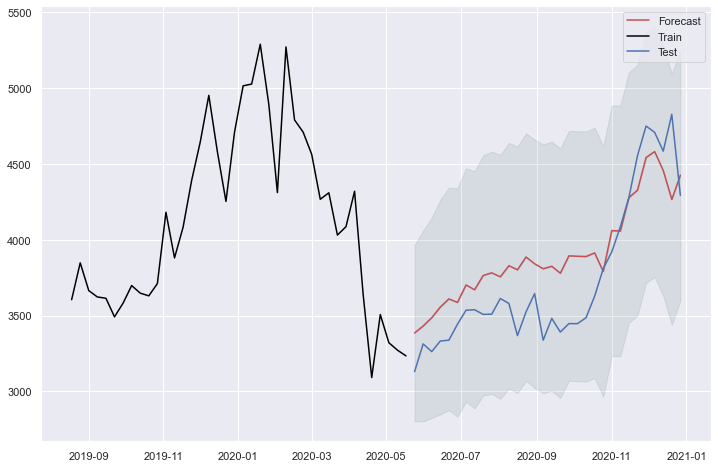

In [142]:
#graph
plt.figure(figsize=(12, 8))
plt.plot(forecast['Forecast'], color='r');
plt.plot(train.iloc[-40:], color='black')
plt.plot(test, color='b')
plt.fill_between(forecast.index, forecast['upper_ci'], forecast['Forecast'], alpha = 0.1, color='darkslategrey')
plt.fill_between(forecast.index, forecast['lower_ci'], forecast['Forecast'], alpha = 0.1, color='darkslategrey')
plt.legend(['Forecast', 'Train', 'Test']);

# Unobserved Components Model
UCMs are a class of structural time series models that decompose a series into trend, seasonal, cyclical, and irregular components. They are the backbone of most time series model, and offer a flexible framework for modelling different and complex processes. UCMs can also be cast into [state space form](https://www.stat.tamu.edu/~suhasini/teaching673/introduction.pdf), and then solved using the powerful [Kalman filter](https://en.wikipedia.org/wiki/Kalman_filter).

                                 Unobserved Components Results                                 
Dep. Variable:                                       y   No. Observations:                 2192
Model:                                 fixed intercept   Log Likelihood              -14686.588
                      + stochastic freq_seasonal(7(1))   AIC                          29377.176
                   + stochastic freq_seasonal(365(16))   BIC                          29388.529
Date:                                 Thu, 04 Feb 2021   HQIC                         29381.329
Time:                                         14:08:39                                         
Sample:                                              0                                         
                                                - 2192                                         
Covariance Type:                                   opg                                         
                                   coef 

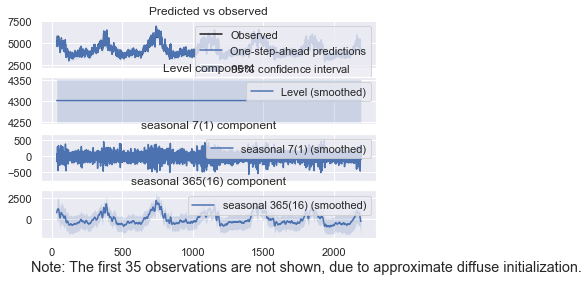

In [36]:
model = sm.tsa.UnobservedComponents(energy_df.values,
                                    level = 'fixed intercept',
                                    freq_seasonal=[{'period': 7,
                                                    'harmonics': 1},
                                                    {'period': 365,
                                                     'harmonics': 16}])
res_f = model.fit(disp=False)
# The first state variable holds our estimate of the intercept
print(res_f.summary())
print("fixed intercept estimated as {0:.3f}".format(res_f.smoother_results.smoothed_state[0,-1:][0]))

res_f.plot_components()
plt.show()

In [37]:
from datetime import datetime
def plot_forecast(series, resultsclass, start_date, end_date, dynamic):
    #get datetime fron the string dates
    start_date_dt = datetime.strptime(start_date, '%Y-%m-%d')
    end_date_dt = datetime.strptime(end_date, '%Y-%m-%d')
    #new index for the foreacast df
    new_index = pd.date_range(start_date_dt, end_date_dt)
    #calculate int indices
    index_start_date = series.index.get_loc(start_date)
    index_end_date = index_start_date + len(new_index)-1
    #get the forecast
    df = resultsclass.get_prediction(index_start_date, index_end_date, dynamic).summary_frame()
    df.index = new_index
    #graph
    plt.figure(figsize=(12, 8))
    plt.plot(df['mean'], color='r');
    plt.plot(series.loc[series.index>start_date], color='black')
    plt.fill_between(df.index, df['mean_ci_lower'], df['mean'], alpha = 0.1, color='darkslategrey')
    plt.fill_between(df.index, df['mean_ci_upper'], df['mean'], alpha = 0.1, color='darkslategrey')
    
    return()


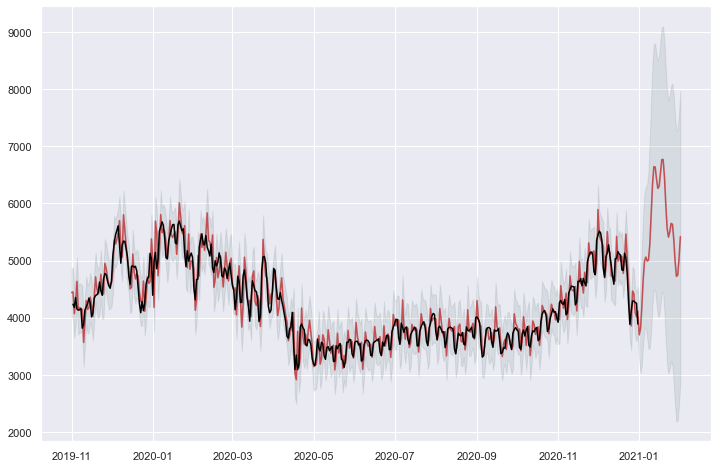

In [38]:
plot_forecast(energy_df, res_f, '2019-11-01', '2021-02-01', False);

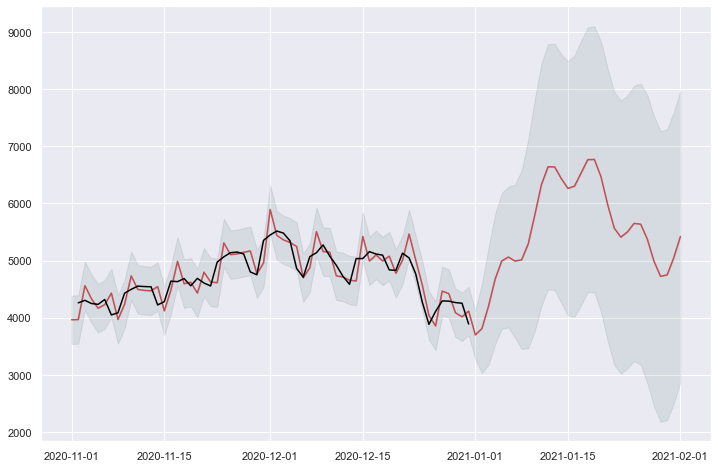

In [39]:
plot_forecast(energy_df, res_f, '2020-11-01', '2021-02-01', False);

# Theta model

In [41]:
from statsmodels.tsa.forecasting.theta import ThetaModel
tm = ThetaModel(energy_df)
res = tm.fit()
print(res.summary())

                              ThetaModel Results                              
Dep. Variable:                   Load   No. Observations:                 2192
Method:                       OLS/SES   Deseasonalized:                   True
Date:                Thu, 04 Feb 2021   Deseas. Method:         Multiplicative
Time:                        14:09:00   Period:                              7
Sample:                    01-01-2015                                         
                         - 12-31-2020                                         
   Parameter Estimates    
           Parameters     
--------------------------
b0    -0.09973647707028749
alpha   0.9998483362657071
--------------------------


# Exponential Smoothing
Exponential smoothing applies different dampening weights to past observations of the series; the intuition behind it is that the further away in the past an observation happened, the less it should matter for the forecast. 

$\hat{y}_{T+1|T} = \alpha y_T + \alpha(1-\alpha) y_{T-1} + \alpha(1-\alpha)^2 y_{T-2} + ...$, where $0\leq \alpha \leq 1$ is the smoothing parameter.
### Simple exponential smoothing
 - for data with no clear trend or seasonality

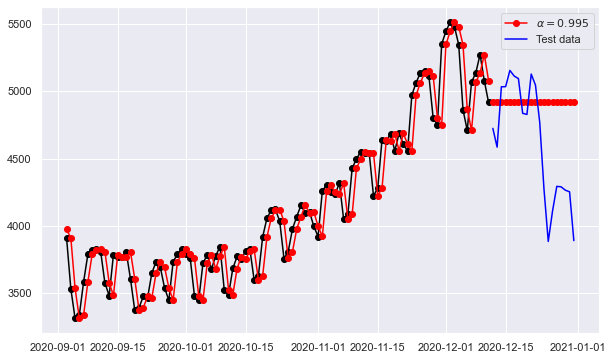

In [47]:
train, test = train_test_split(energy_df, train_size=len(energy_df)-20)
from statsmodels.tsa.holtwinters import ExponentialSmoothing, SimpleExpSmoothing, Holt

fit_ses = SimpleExpSmoothing(train, initialization_method="estimated").fit()
fcast_ses = fit_ses.forecast(20).rename(r'$\alpha=%s$'%fit_ses.model.params['smoothing_level'])

plt.figure(figsize=(10, 6))
plt.plot(train.iloc[-100:], marker='o', color='black')
plt.plot(fit_ses.fittedvalues.iloc[-100:], marker='o', color='red')
line1, = plt.plot(fcast_ses, marker='o', color='red')
line2, = plt.plot(test,  color='blue')

plt.legend([line1, line2,], [fcast_ses.name, 'Test data']);

### Holt's Method

C:\Users\GerganaMarkova\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


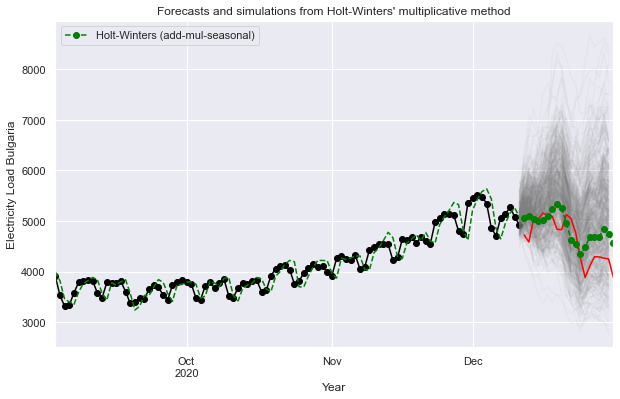

In [48]:
fit = ExponentialSmoothing(train, seasonal_periods=365, trend='mul', seasonal='mul', initialization_method="estimated").fit()
simulations = fit.simulate(20, anchor='2020-12-11', repetitions=500, error='mul', random_errors='bootstrap')

ax = train.iloc[-100:].plot(figsize=(10,6), marker='o', color='black',
               title="Forecasts and simulations from Holt-Winters' multiplicative method" )
ax.set_ylabel("Electricity Load Bulgaria")
ax.set_xlabel("Year")
fit.fittedvalues.iloc[-100:].plot(ax=ax, style='--', color='green')
simulations.plot(ax=ax, style='-', alpha=0.05, color='grey', legend=False)
test.rename('Test data').plot(ax=ax, style='-',  color='red')
fit.forecast(20).rename('Holt-Winters (add-mul-seasonal)').plot(ax=ax, style='--', marker='o', color='green', legend=True)
plt.show()

# TBATS and BATS
good for complex seasonality

In [111]:
from tbats import TBATS, BATS

In [120]:
train, test = train_test_split(energy_df, train_size=len(energy_df)-100)

# Fit the model
estimator = TBATS(seasonal_periods=(7, 365.25))
model_tbats = estimator.fit(train)

print(model_tbats.summary())

Use Box-Cox: True
Use trend: True
Use damped trend: True
Seasonal periods: [  7.   365.25]
Seasonal harmonics [ 3 11]
ARMA errors (p, q): (0, 0)
Box-Cox Lambda 0.000000
Smoothing (Alpha): 1.203012
Trend (Beta): -0.277263
Damping Parameter (Phi): 0.800000
Seasonal Parameters (Gamma): [ 7.10256221e-09  1.42718421e-07 -6.85976046e-08  2.87565010e-07]
AR coefficients []
MA coefficients []
Seed vector [ 8.45479382e+00  1.15129300e-03  2.57329689e-02  9.06978557e-04
 -3.37099101e-03 -2.69178972e-02  1.75832362e-02 -5.15615067e-03
  1.69567367e-01  6.12795621e-02 -8.55357855e-03  6.24152916e-04
 -4.12236174e-03 -9.98909753e-03 -1.08333351e-02 -6.36218391e-03
 -1.92581816e-03 -4.95015474e-03 -1.04971808e-02  5.56083017e-03
  4.11880999e-02 -1.37942979e-02 -5.35849067e-04  4.61626532e-03
  1.09794632e-03  2.31040336e-03  6.12661223e-03  1.52866579e-02
  8.38032551e-03  9.26863396e-03]

AIC 36409.912343


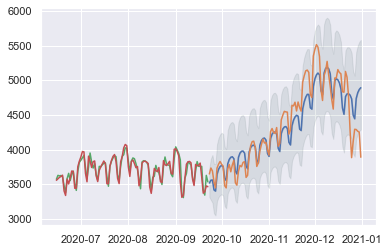

In [121]:
forecast_tbats = pd.DataFrame(model_tbats.forecast(steps=len(test), confidence_level=0.95)[1], index = test.index)
plt.plot(forecast_tbats['mean'], label='TBATS')
plt.plot(test, label = 'Test');
plt.plot((pd.DataFrame(model_tbats.y_hat, index = train.index).iloc[-100:]))
plt.plot((train.iloc[-100:]))
plt.fill_between(test.index, forecast_tbats['lower_bound'], forecast_tbats['mean'], alpha = 0.1, color='darkslategrey')
plt.fill_between(test.index, forecast_tbats['upper_bound'], forecast_tbats['mean'], alpha = 0.1, color='darkslategrey');

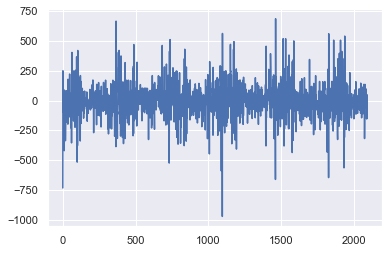

In [122]:
plt.plot(model_tbats.resid);